## Elo Merchant Category Recommendation

The dataset has information on card activity and transactions from both a historical period and new merchant period. Our challenge is to predict the user loyalty score based on anonymized features and transaction data.

### Import modules and load the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection  import KFold

/Users/liz/anaconda/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
new_transactions = pd.read_csv('new_merchant_transactions.csv')
historical_transactions = pd.read_csv('historical_transactions.csv')
merchants = pd.read_csv('merchants.csv')

### Data validation and exploration - Training dataframe

A description of each column included in the dataset.

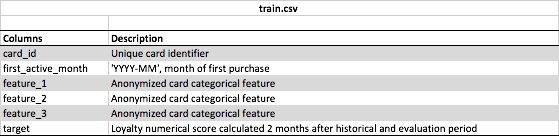

Validate that the correct columns are present and determine the data type of each column.

In [3]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [4]:
train.shape

(201917, 6)

In [5]:
train.dtypes

first_active_month     object
card_id                object
feature_1               int64
feature_2               int64
feature_3               int64
target                float64
dtype: object

In [6]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


In [7]:
test.shape

(123623, 5)

In [8]:
test.dtypes

first_active_month    object
card_id               object
feature_1              int64
feature_2              int64
feature_3              int64
dtype: object

In [9]:
test['first_active_month'].fillna('2016-07', inplace=True)

Since the first_active_month feature is an object (string), convert this feature to datetime and create separate columns for month and year.

In [10]:
def date_time_year_month(df):
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['year'] = df['first_active_month'].dt.year
    df['month'] = df['first_active_month'].dt.month
    return df

date_time_year_month(train)
date_time_year_month(test)

,first_active_month,card_id,feature_1,feature_2,feature_3,year,month
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,2017,4
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,2017,1
2,2017-08-01,C_ID_b709037bc5,5,1,1,2017,8
3,2017-12-01,C_ID_d27d835a9f,2,1,0,2017,12
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1,2015,12
5,2017-07-01,C_ID_5814b4f13c,5,1,1,2017,7
6,2017-10-01,C_ID_a1b3c75277,1,2,0,2017,10
7,2017-02-01,C_ID_f7cada36d3,3,1,1,2017,2
8,2017-07-01,C_ID_9d2bc8dfc4,4,3,0,2017,7
9,2016-03-01,C_ID_6d8dba8475,5,1,1,2016,3


In [11]:
train.dtypes

first_active_month    datetime64[ns]
card_id                       object
feature_1                      int64
feature_2                      int64
feature_3                      int64
target                       float64
year                           int64
month                          int64
dtype: object

In [12]:
test.dtypes

first_active_month    datetime64[ns]
card_id                       object
feature_1                      int64
feature_2                      int64
feature_3                      int64
year                           int64
month                          int64
dtype: object

Look for missing data.

In [13]:
train.isnull().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
year                  0
month                 0
dtype: int64

In [14]:
test.isnull().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
year                  0
month                 0
dtype: int64

Determine the distribution of the target variable, loyalty score.

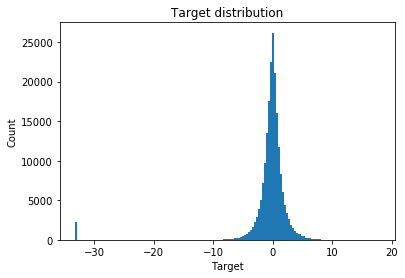

In [15]:
target = train['target']
plt.hist(target, bins = 150)
plt.xlabel('Target')
plt.ylabel('Count')
plt.title("Target distribution")
plt.show()


In [16]:
(train['target']<-30).sum()

2207

In [17]:
((train['target']<-30).sum())/(train['target'].count())


0.010930233709890698

In [18]:
(train['target']>10).sum()

48

In [19]:
((train['target']>10).sum())/(train['target'].count())

0.00023772143999762279

In [20]:
train.describe()

,feature_1,feature_2,feature_3,target,year,month
count,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000
mean,3.105311,1.745410,0.565569,-0.393636,2016.509298,7.378745
std,1.186160,0.751362,0.495683,3.850500,0.788199,3.340718
min,1.000000,1.000000,0.000000,-33.219281,2011.000000,1.000000
25%,2.000000,1.000000,0.000000,-0.883110,2016.000000,5.000000
50%,3.000000,2.000000,1.000000,-0.023437,2017.000000,8.000000
75%,4.000000,2.000000,1.000000,0.765453,2017.000000,10.000000
max,5.000000,3.000000,1.000000,17.965068,2018.000000,12.000000


In [21]:
train[train['target']<-30].describe()


,feature_1,feature_2,feature_3,target,year,month
count,2207.000000,2207.000000,2207.000000,2.207000e+03,2207.000000,2207.000000
mean,3.224286,1.782510,0.591300,-3.321928e+01,2016.187132,6.312642
std,1.207783,0.810069,0.491705,1.193982e-12,0.950668,3.511429
min,1.000000,1.000000,0.000000,-3.321928e+01,2012.000000,1.000000
25%,2.000000,1.000000,0.000000,-3.321928e+01,2016.000000,3.000000
50%,3.000000,2.000000,1.000000,-3.321928e+01,2016.000000,6.000000
75%,4.000000,2.000000,1.000000,-3.321928e+01,2017.000000,9.000000
max,5.000000,3.000000,1.000000,-3.321928e+01,2017.000000,12.000000


Next, consider the anonymized features of the dataset. I considered using one-hot encoding for the anonymized features, but since I'm using the LightGBM model, I will label them as categorical features in the model instead.

In [22]:
train['feature_1'].value_counts()


3    73573
2    55797
5    40625
4    19885
1    12037
Name: feature_1, dtype: int64

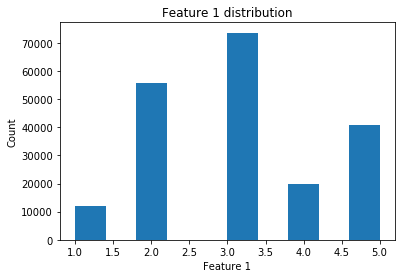

In [23]:
feature_1 = train['feature_1']
plt.hist(feature_1)
plt.xlabel('Feature 1')
plt.ylabel('Count')
plt.title("Feature 1 distribution")
plt.show()

In [24]:
train['feature_2'].value_counts()

1    89242
2    74839
3    37836
Name: feature_2, dtype: int64

In [25]:
test['feature_2'].value_counts()

1    54775
2    45993
3    22855
Name: feature_2, dtype: int64

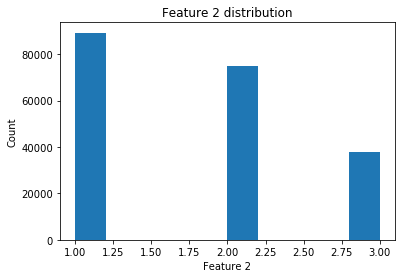

In [26]:
feature_2 = train['feature_2']
plt.hist(feature_2)
plt.xlabel('Feature 2')
plt.ylabel('Count')
plt.title("Feature 2 distribution")
plt.show()

In [27]:
train['feature_3'].value_counts()

1    114198
0     87719
Name: feature_3, dtype: int64

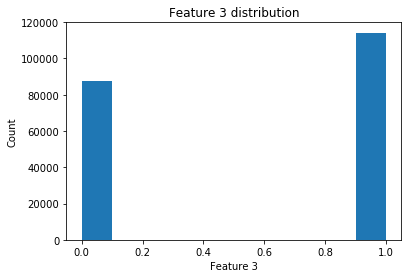

In [28]:
feature_3 = train['feature_3']
plt.hist(feature_3)
plt.xlabel('Feature 3')
plt.ylabel('Count')
plt.title("Feature 3 distribution")
plt.show()


Correlation between anonymized features and target.

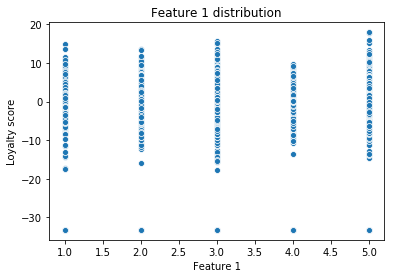

In [29]:
# Feature 1 scatter plot

sns.scatterplot(x="feature_1", y="target", data=train)
plt.xlabel('Feature 1')
plt.ylabel('Loyalty score')
plt.title("Feature 1 distribution")
plt.show()

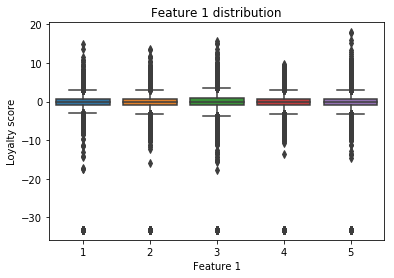

In [30]:
# Feature 1 box plot

sns.boxplot(x="feature_1", y="target", data=train)
plt.xlabel('Feature 1')
plt.ylabel('Loyalty score')
plt.title("Feature 1 distribution")
plt.show()

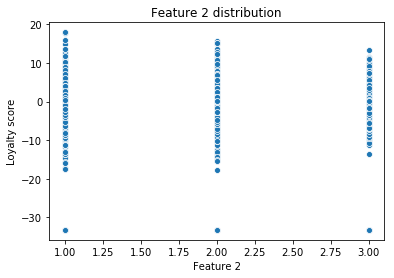

In [31]:
# Feature 2 scatter plot

sns.scatterplot(x="feature_2", y="target", data=train)
plt.xlabel('Feature 2')
plt.ylabel('Loyalty score')
plt.title("Feature 2 distribution")
plt.show()

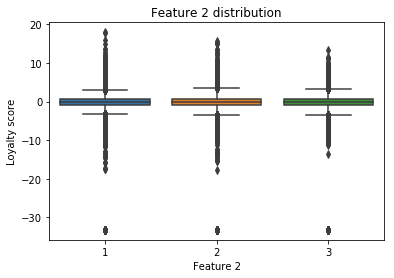

In [32]:
# Feature 2 box plot

sns.boxplot(x="feature_2", y="target", data=train)
plt.xlabel('Feature 2')
plt.ylabel('Loyalty score')
plt.title("Feature 2 distribution")
plt.show()

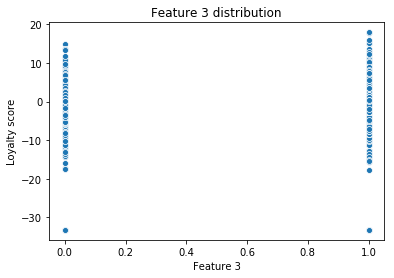

In [33]:
#Feature 3 scatterplot

sns.scatterplot(x="feature_3", y="target", data=train)
plt.xlabel('Feature 3')
plt.ylabel('Loyalty score')
plt.title("Feature 3 distribution")
plt.show()

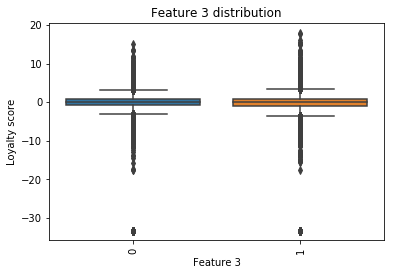

In [34]:
#Feature 3 boxplot

sns.boxplot(x="feature_3", y="target", data=train)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 3')
plt.ylabel('Loyalty score')
plt.title("Feature 3 distribution")
plt.show()

Look at the descriptive statistics of the train dataframe. 

In [35]:
train.describe()

,feature_1,feature_2,feature_3,target,year,month
count,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000
mean,3.105311,1.745410,0.565569,-0.393636,2016.509298,7.378745
std,1.186160,0.751362,0.495683,3.850500,0.788199,3.340718
min,1.000000,1.000000,0.000000,-33.219281,2011.000000,1.000000
25%,2.000000,1.000000,0.000000,-0.883110,2016.000000,5.000000
50%,3.000000,2.000000,1.000000,-0.023437,2017.000000,8.000000
75%,4.000000,2.000000,1.000000,0.765453,2017.000000,10.000000
max,5.000000,3.000000,1.000000,17.965068,2018.000000,12.000000


In [36]:
train.groupby('feature_1').describe()

feature_2                                              feature_3  \
              count      mean       std  min  25%  50%  75%  max     count   
feature_1                                                                    
1           12037.0  1.683310  0.815110  1.0  1.0  1.0  2.0  3.0   12037.0   
2           55797.0  1.683209  0.679055  1.0  1.0  2.0  2.0  3.0   55797.0   
3           73573.0  1.999130  0.817395  1.0  1.0  2.0  3.0  3.0   73573.0   
4           19885.0  1.727131  0.759881  1.0  1.0  2.0  2.0  3.0   19885.0   
5           40625.0  1.398695  0.489636  1.0  1.0  1.0  2.0  2.0   40625.0   

                 ...      target                year                         \
          mean   ...         75%        max    count         mean       std   
feature_1        ...                                                          
1          0.0   ...    0.666923  15.011358  12037.0  2016.786409  0.449498   
2          0.0   ...    0.768908  13.592223  55797.0  2016.656039  0.563972   
3          1.0   ...    0.837927  15.606405  73573.0  2016.373833  0.978734   
4          0.0   ...    0.728345   9.665204  19885.0  2016.699774  0.532472   
5          1.0   ...    0.692869  17.965068  40625.0  2016.377748  0.772603   

                                                   
              min     25%     50%     75%     max  
feature_1                                          
1          2015.0  2017.0  2017.0  2017.0  2018.0  
2          2014.0  2016.0  2017.0  2017.0  2018.0  
3          2011.0  2016.0  2017.0  2017.0  2018.0  
4          2015.0  2016.0  2017.0  2017.0  2018.0  
5          2013.0  2016.0  2017.0  2017.0  2018.0  

[5 rows x 40 columns]

In [37]:
train.groupby('feature_2').describe()

feature_1                                              feature_3  \
              count      mean       std  min  25%  50%  75%  max     count   
feature_2                                                                    
1           89242.0  3.230071  1.308158  1.0  2.0  3.0  5.0  5.0   89242.0   
2           74839.0  3.122690  1.192285  1.0  2.0  3.0  4.0  5.0   74839.0   
3           37836.0  2.776668  0.717742  1.0  2.0  3.0  3.0  4.0   37836.0   

                      ...      target                year               \
               mean   ...         75%        max    count         mean   
feature_2             ...                                                
1          0.549495   ...    0.738072  17.965068  89242.0  2016.598373   
2          0.542685   ...    0.799371  15.606405  74839.0  2016.539385   
3          0.648747   ...    0.766570  13.350895  37836.0  2016.239692   

                                                             
                std     min     25%     50%     75%     max  
feature_2                                                    
1          0.755855  2011.0  2016.0  2017.0  2017.0  2018.0  
2          0.570384  2013.0  2016.0  2017.0  2017.0  2018.0  
3          1.109604  2011.0  2016.0  2017.0  2017.0  2018.0  

[3 rows x 40 columns]

In [38]:
train.groupby('feature_3').describe()

feature_1                                              feature_2  \
              count      mean       std  min  25%  50%  75%  max     count   
feature_3                                                                    
0           87719.0  2.316157  0.971616  1.0  2.0  2.0  2.0  4.0   87719.0   
1          114198.0  3.711484  0.957479  3.0  3.0  3.0  5.0  5.0  114198.0   

                      ...      target                 year               \
               mean   ...         75%        max     count         mean   
feature_3             ...                                                 
0          1.693179   ...    0.745114  15.011358   87719.0  2016.683843   
1          1.785530   ...    0.783653  17.965068  114198.0  2016.375225   

                                                             
                std     min     25%     50%     75%     max  
feature_3                                                    
0          0.544336  2014.0  2016.0  2017.0  2017.0  2018.0  
1          0.910765  2011.0  2016.0  2017.0  2017.0  2018.0  

[2 rows x 40 columns]

There are no apparent relationships between the feature variables and the loyalty score target variable in scatter or box plots, but based on the descriptive statistics, there might be some interesting relationships that can be leveraged in the model.

### Data Validation - Transactions data

The transactions dataframes, i.e. historical transactions and new transactions, both have the same columns and datatypes.

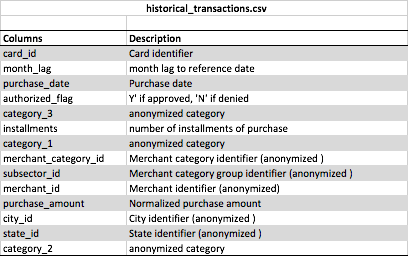 

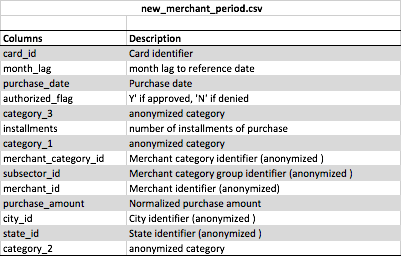

In [39]:
historical_transactions.head()


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [40]:
historical_transactions.shape

(29112361, 14)

In [41]:
new_transactions.shape

(1963031, 14)

In [42]:
historical_transactions.dtypes

authorized_flag          object
card_id                  object
city_id                   int64
category_1               object
installments              int64
category_3               object
merchant_category_id      int64
merchant_id              object
month_lag                 int64
purchase_amount         float64
purchase_date            object
category_2              float64
state_id                  int64
subsector_id              int64
dtype: object

In [43]:
new_transactions.dtypes

authorized_flag          object
card_id                  object
city_id                   int64
category_1               object
installments              int64
category_3               object
merchant_category_id      int64
merchant_id              object
month_lag                 int64
purchase_amount         float64
purchase_date            object
category_2              float64
state_id                  int64
subsector_id              int64
dtype: object

The purchase date feature is also currently a string (object) datatype instead of datetime. Here the purchase date feature is converted to datetime format, other date features are extracted from that column, and numerical data is mapped onto the authorization feature, anonymized category 1, and anonymized category 3.

Code from this kernel was used: https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/comments

In [ ]:
#def sample_data(df):
#    new_df = df.sample(1000)
#    return new_df

#hist_sample = sample_data(historical_transactions)
#new_sample = sample_data(new_transactions)

In [44]:
for df in [historical_transactions, new_transactions]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0})
    df['category_3'] = df['category_3'].map({'A':1, 'B':2, 'C':3})

Look for missing data.

In [45]:
historical_transactions.isnull().sum()

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               178159
merchant_category_id          0
merchant_id              138481
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2652864
state_id                      0
subsector_id                  0
year                          0
weekofyear                    0
month                         0
dayofweek                     0
weekend                       0
hour                          0
dtype: int64

In [46]:
new_transactions.isnull().sum()

authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
year                         0
weekofyear                   0
month                        0
dayofweek                    0
weekend                      0
hour                         0
dtype: int64

In [47]:
historical_transactions['merchant_id'].isnull().sum() / historical_transactions['merchant_id'].count()

0.0047795117533447366

First, I'll deal with the missing merchant ID data. Since the data is pretty much entirely anonymized, there is no way to determine the merchant ID from a combination of other data in the dataset (such as the address). Missing merchant ID data only represents less than 0.5% of the dataset as a whole, so it is reasonable to drop the rows with missing merchant ID.

In [48]:
def drop_nans(df):
    df.dropna(subset=['merchant_id'], inplace=True)
    return df

drop_nans(historical_transactions)
drop_nans(new_transactions)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,year,weekofyear,month,dayofweek,weekend,hour
0,1,C_ID_415bb3a509,107,0,1,2.0,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19,2018,10,3,6,1,14
1,1,C_ID_415bb3a509,140,0,1,2.0,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19,2018,12,3,0,0,18
2,1,C_ID_415bb3a509,330,0,1,2.0,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14,2018,17,4,3,0,14
3,1,C_ID_415bb3a509,-1,1,1,2.0,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8,2018,10,3,2,0,9
4,1,C_ID_ef55cf8d4b,-1,1,1,2.0,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29,2018,12,3,3,0,21
5,1,C_ID_ef55cf8d4b,231,0,1,2.0,367,M_ID_8874615e00,2,-0.633007,2018-04-02 12:53:28,1.0,9,16,2018,14,4,0,0,12
6,1,C_ID_ef55cf8d4b,69,0,1,2.0,333,M_ID_6d061b5ddc,1,5.263697,2018-03-28 19:50:19,1.0,9,10,2018,13,3,2,0,19
7,1,C_ID_ef55cf8d4b,231,0,1,2.0,307,M_ID_df1e022f41,2,-0.553787,2018-04-05 08:06:52,1.0,9,19,2018,14,4,3,0,8
8,1,C_ID_ef55cf8d4b,69,0,1,2.0,278,M_ID_d15eae0468,2,-0.596643,2018-04-07 18:37:40,1.0,9,37,2018,14,4,5,1,18
9,1,C_ID_ef55cf8d4b,69,0,1,2.0,437,M_ID_5f9bffd028,1,-0.607191,2018-03-17 18:10:41,1.0,9,15,2018,11,3,5,1,18


For the missing category 2 and category 3 data, I'll impute the median and the most common value, respectively.

In [49]:
historical_transactions['category_2'].describe()

count    2.633105e+07
mean     2.194489e+00
std      1.531730e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      5.000000e+00
Name: category_2, dtype: float64

In [50]:
new_transactions['category_2'].describe()

count    1.826614e+06
mean     2.197007e+00
std      1.528093e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      5.000000e+00
Name: category_2, dtype: float64

In [51]:
historical_transactions['category_3'].describe()

count    2.880293e+07
mean     1.531581e+00
std      6.140759e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      3.000000e+00
Name: category_3, dtype: float64

In [52]:
new_transactions['category_3'].describe()

count    1.883075e+06
mean     1.596194e+00
std      6.314003e-01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      3.000000e+00
Name: category_3, dtype: float64

In [53]:
def impute(df, column, value):
    df[column].fillna(value, inplace=True)
    return df

impute(new_transactions, 'category_2', 1.0)
impute(new_transactions, 'category_3', 'A')
impute(historical_transactions, 'category_2', 1.0)
impute(historical_transactions, 'category_3', 'A')


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,year,weekofyear,month,dayofweek,weekend,hour
0,1,C_ID_4e6213e9bc,88,0,0,1,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,2017,25,6,6,1,15
1,1,C_ID_4e6213e9bc,88,0,0,1,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,2017,28,7,5,1,12
2,1,C_ID_4e6213e9bc,88,0,0,1,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,2017,32,8,2,0,22
3,1,C_ID_4e6213e9bc,88,0,0,1,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,2017,35,9,5,1,10
4,1,C_ID_4e6213e9bc,88,0,0,1,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,2017,10,3,4,0,1
5,1,C_ID_4e6213e9bc,333,0,0,1,80,M_ID_50af771f8d,0,-0.734887,2018-02-24 08:45:05,1.0,9,37,2018,8,2,5,1,8
6,1,C_ID_4e6213e9bc,88,0,0,1,278,M_ID_5e8220e564,-11,-0.716855,2017-03-21 00:10:51,1.0,16,37,2017,12,3,1,0,0
7,1,C_ID_4e6213e9bc,3,0,0,1,80,M_ID_9d41786a50,-3,-0.657049,2017-11-18 20:05:55,1.0,16,37,2017,46,11,5,1,20
8,1,C_ID_4e6213e9bc,88,0,0,1,80,M_ID_979ed661fc,-8,-0.737967,2017-06-01 22:02:56,1.0,16,37,2017,22,6,3,0,22
9,1,C_ID_4e6213e9bc,88,0,0,1,80,M_ID_74ba14b5fc,-11,-0.715352,2017-03-16 15:41:22,1.0,16,37,2017,11,3,3,0,15


In [55]:
for df in [historical_transactions, new_transactions]:
    df['category_3'] = df['category_3'].map({'A':1, 'B':2, 'C':3})

Next, I'll aggregate the transaction data on card ID and merge the aggregated transactions to the training dataset based on card ID.

In [56]:
agg_transactions = {'authorized_flag': ['sum', 'mean'],
                    'city_id': ['nunique'],
                    'category_1': ['sum', 'mean'],
                    'installments': ['min', 'mean', 'median', 'max'],
                    'category_3': ['min', 'mean', 'median', 'max'],
                    'merchant_category_id': ['nunique'],
                    'merchant_id': ['nunique'],
                    'month_lag': ['min', 'median', 'max', 'mean'],
                    'purchase_amount': ['min', 'median', 'max', 'sum', 'mean', 'var'],
                    'category_2': ['min', 'mean', 'median', 'max'],
                    'state_id': ['nunique'],
                    'subsector_id': ['nunique'],
                    'year': ['nunique', 'mean', 'median'],
                    'weekofyear': ['nunique', 'mean', 'median'],
                    'month': ['nunique', 'mean', 'median'],
                    'dayofweek': ['mean', 'median'],
                    'weekend': ['sum', 'mean'],
                    'hour': ['mean']
                    }

def aggregate_and_format(df, prefix):
    new_df = df.groupby(by='card_id').agg(agg_transactions)
    new_df.columns = [prefix + '_'.join(col).strip() for col in new_df.columns.values]
    new_df.reset_index(inplace=True)
    return new_df

new_agg = aggregate_and_format(new_transactions, 'new_')
hist_agg = aggregate_and_format(historical_transactions, 'hist_')

In [57]:
train_hist = pd.merge(train, hist_agg, on='card_id', how='left')
test_hist = pd.merge(test, hist_agg, on='card_id', how='left')

In [58]:
training_data = pd.merge(train_hist, new_agg, on='card_id', how='left')
test_data = pd.merge(test_hist, new_agg, on='card_id', how='left')

In [59]:
training_data.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,year,month,hist_authorized_flag_sum,hist_authorized_flag_mean,...,new_weekofyear_mean,new_weekofyear_median,new_month_nunique,new_month_mean,new_month_median,new_dayofweek_mean,new_dayofweek_median,new_weekend_sum,new_weekend_mean,new_hour_mean
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,2017,6,242,0.952756,...,13.304348,13.0,2.0,3.478261,3.0,3.130435,4.0,6.0,0.260870,12.869565
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,2017,1,339,0.968571,...,9.000000,9.0,2.0,2.500000,2.5,1.500000,1.0,0.0,0.000000,11.166667
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,2016,8,41,0.953488,...,17.000000,17.0,1.0,4.000000,4.0,5.000000,5.0,1.0,1.000000,17.000000
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,2017,9,77,1.000000,...,13.857143,14.0,2.0,3.714286,4.0,3.285714,2.0,3.0,0.428571,13.000000
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,2017,11,127,0.962121,...,13.361111,13.5,2.0,3.555556,4.0,3.277778,4.0,12.0,0.333333,14.722222


In [60]:
training_data.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'target', 'year', 'month', 'hist_authorized_flag_sum',
       'hist_authorized_flag_mean', 'hist_city_id_nunique',
       'hist_category_1_sum', 'hist_category_1_mean', 'hist_installments_min',
       'hist_installments_mean', 'hist_installments_median',
       'hist_installments_max', 'hist_category_3_min', 'hist_category_3_mean',
       'hist_category_3_median', 'hist_category_3_max',
       'hist_merchant_category_id_nunique', 'hist_merchant_id_nunique',
       'hist_month_lag_min', 'hist_month_lag_median', 'hist_month_lag_max',
       'hist_month_lag_mean', 'hist_purchase_amount_min',
       'hist_purchase_amount_median', 'hist_purchase_amount_max',
       'hist_purchase_amount_sum', 'hist_purchase_amount_mean',
       'hist_purchase_amount_var', 'hist_category_2_min',
       'hist_category_2_mean', 'hist_category_2_median', 'hist_category_2_max',
       'hist_state_id_nunique', 'hist_subsector_id

In [61]:
test_data.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'year', 'month', 'hist_authorized_flag_sum',
       'hist_authorized_flag_mean', 'hist_city_id_nunique',
       'hist_category_1_sum', 'hist_category_1_mean', 'hist_installments_min',
       'hist_installments_mean', 'hist_installments_median',
       'hist_installments_max', 'hist_category_3_min', 'hist_category_3_mean',
       'hist_category_3_median', 'hist_category_3_max',
       'hist_merchant_category_id_nunique', 'hist_merchant_id_nunique',
       'hist_month_lag_min', 'hist_month_lag_median', 'hist_month_lag_max',
       'hist_month_lag_mean', 'hist_purchase_amount_min',
       'hist_purchase_amount_median', 'hist_purchase_amount_max',
       'hist_purchase_amount_sum', 'hist_purchase_amount_mean',
       'hist_purchase_amount_var', 'hist_category_2_min',
       'hist_category_2_mean', 'hist_category_2_median', 'hist_category_2_max',
       'hist_state_id_nunique', 'hist_subsector_id_nunique',

In [62]:
training_data.dtypes

first_active_month                   datetime64[ns]
card_id                                      object
feature_1                                     int64
feature_2                                     int64
feature_3                                     int64
target                                      float64
year                                          int64
month                                         int64
hist_authorized_flag_sum                      int64
hist_authorized_flag_mean                   float64
hist_city_id_nunique                          int64
hist_category_1_sum                           int64
hist_category_1_mean                        float64
hist_installments_min                         int64
hist_installments_mean                      float64
hist_installments_median                    float64
hist_installments_max                         int64
hist_category_3_min                         float64
hist_category_3_mean                        float64
hist_categor

In [63]:
X = training_data
y = training_data['target']

In [67]:
X.drop(['card_id', 'first_active_month', 'target'], axis=1, inplace=True)
X_test = test_data.drop(['card_id', 'first_active_month'], axis=1)

In [68]:
X.astype('float32', inplace=True)
y.astype('float32', inplace=True)
X_test.astype('float32', inplace=True)

,feature_1,feature_2,feature_3,year,month,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_city_id_nunique,hist_category_1_sum,hist_category_1_mean,...,new_weekofyear_mean,new_weekofyear_median,new_month_nunique,new_month_mean,new_month_median,new_dayofweek_mean,new_dayofweek_median,new_weekend_sum,new_weekend_mean,new_hour_mean
0,3.0,3.0,1.0,2017.0,4.0,44.0,0.647059,7.0,23.0,0.338235,...,7.000000,7.0,1.0,2.000000,2.0,3.666667,4.0,1.0,0.333333,13.666667
1,2.0,3.0,0.0,2017.0,1.0,77.0,0.987179,4.0,2.0,0.025641,...,12.444445,11.0,2.0,3.444444,3.0,3.000000,4.0,3.0,0.333333,15.222222
2,5.0,1.0,1.0,2017.0,8.0,9.0,0.692308,4.0,1.0,0.076923,...,10.000000,10.0,1.0,3.000000,3.0,2.000000,2.0,0.0,0.000000,13.500000
3,2.0,1.0,0.0,2017.0,12.0,26.0,1.000000,1.0,0.0,0.000000,...,12.100000,12.0,2.0,3.300000,3.0,3.200000,3.0,3.0,0.300000,18.200001
4,5.0,1.0,1.0,2015.0,12.0,87.0,0.790909,5.0,0.0,0.000000,...,10.500000,10.0,2.0,3.166667,3.0,4.000000,3.5,2.0,0.333333,8.000000
5,5.0,1.0,1.0,2017.0,7.0,12.0,0.750000,5.0,1.0,0.062500,...,11.000000,11.0,1.0,3.000000,3.0,0.000000,0.0,0.0,0.000000,10.000000
6,1.0,2.0,0.0,2017.0,10.0,47.0,1.000000,5.0,1.0,0.021277,...,13.333333,14.0,2.0,3.666667,4.0,3.333333,4.0,2.0,0.222222,14.000000
7,3.0,1.0,1.0,2017.0,2.0,15.0,0.750000,1.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,4.0,3.0,0.0,2017.0,7.0,36.0,0.654545,7.0,27.0,0.490909,...,11.000000,11.0,1.0,3.000000,3.0,5.000000,5.0,1.0,1.000000,15.000000
9,5.0,1.0,1.0,2016.0,3.0,43.0,0.895833,5.0,0.0,0.000000,...,43.111111,41.0,2.0,10.444445,10.0,2.333333,1.0,2.0,0.222222,15.222222


In [117]:
kf = KFold(n_splits=20, random_state=42, shuffle=True)
for dev_index, val_index in kf.split(X):
    X_train, X_valid = X.loc[dev_index,:], X.loc[val_index,:]
    y_train, y_valid = y[dev_index], y[val_index]

In [121]:
# Convert the datasets to LGB format
train_cols = X.columns.tolist()
categorical_cols = ['feature_1', 'feature_2', 'feature_3', 'year', 'month', 
#                   'hist_year_mean', 'hist_year_median',
#                    'hist_weekofyear_mean', 'hist_weekofyear_median', 'hist_month_mean', 'hist_month_median',
#                   'hist_dayofweek_mean', 'hist_dayofweek_median', 'hist_weekend_mean', 'hist_hour_mean', 
#                    'new_year_mean', 'new_year_median','new_weekofyear_mean', 'new_weekofyear_median', 
#                    'new_month_mean', 'new_month_median','new_dayofweek_mean', 'new_dayofweek_median', 
#                    'new_weekend_mean', 'new_hour_mean'
                   ]

dtrain = lgb.Dataset(X_train, y_train, feature_name=train_cols, categorical_feature=categorical_cols, free_raw_data=False)
dvalid = lgb.Dataset(X_valid, y_valid, feature_name=train_cols, categorical_feature=categorical_cols, free_raw_data=False)

#lgb_params = dict(
#    objective = 'regression_l2',
#    boosting = 'gbdt',
#    learning_rate = 0.05,
#    num_leaves = 500,
#    max_depth = 10,
#    min_data_in_leaf = 100,
#    bagging_fraction = 0.75,
#    bagging_freq = 2,
#    feature_fraction = 0.5,
#    max_bin = 100,
#    metric = 'rmse', 
#    seed = 42 
#)

lgb_params = dict(
    objective = 'regression_l2',
    learning_rate = 0.05,
    num_leaves = 30,
    max_depth = -1,
    min_data_in_leaf = 1000,
    bagging_fraction = 0.75,
    bagging_freq = 2,
    feature_fraction = 0.5,
    max_bin = 125,
    metric = 'rmse', 
    seed = 42)
    
evals_result = {}
m = lgb.train(lgb_params, dtrain, num_boost_round=1000, valid_sets=(dvalid,), valid_names=('valid',), verbose_eval=25,
              early_stopping_rounds=100, evals_result=evals_result)

df_result = pd.DataFrame(evals_result['valid'])
pred_y_test = m.predict(X_test, num_iteration=m.best_iteration)


/Users/liz/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/liz/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[25]	valid's rmse: 3.55204
[50]	valid's rmse: 3.52459
[75]	valid's rmse: 3.51503
[100]	valid's rmse: 3.50879
[125]	valid's rmse: 3.50704
[150]	valid's rmse: 3.50409
[175]	valid's rmse: 3.50338
[200]	valid's rmse: 3.50308
[225]	valid's rmse: 3.50322
[250]	valid's rmse: 3.50364
[275]	valid's rmse: 3.50268
[300]	valid's rmse: 3.50301
[325]	valid's rmse: 3.50302
[350]	valid's rmse: 3.5035
[375]	valid's rmse: 3.50449
Early stopping, best iteration is:
[277]	valid's rmse: 3.50243


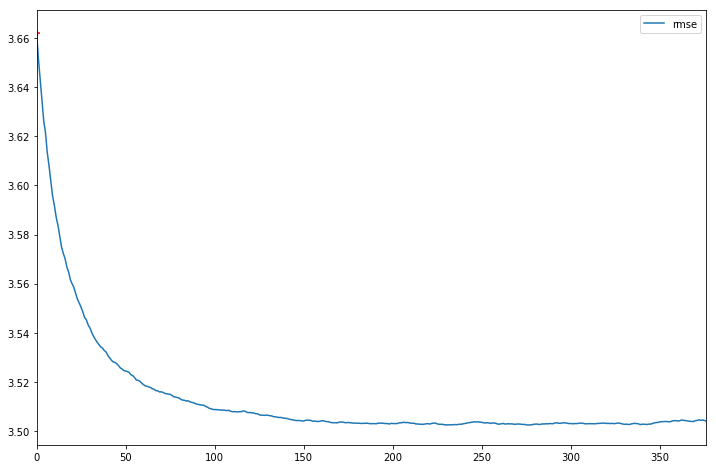

In [122]:
ax = df_result.plot(figsize=(12, 8))
ax.scatter(df_result.idxmax(), df_result.max(), marker='+', color='red')
plt.show()

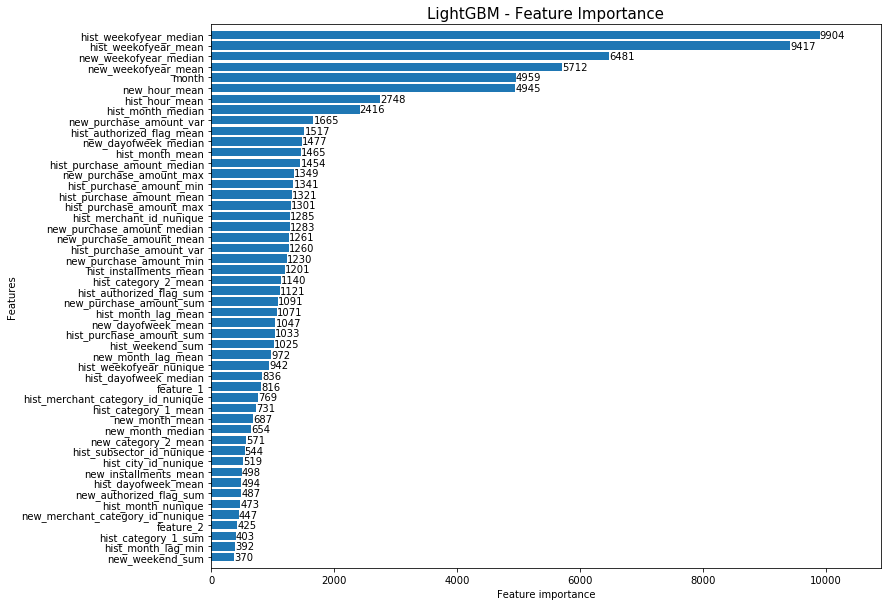

In [106]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(m, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [123]:
submission = pd.DataFrame({"card_id":test_data["card_id"].values})
submission["target"] = pred_y_test
submission.to_csv("submission5.csv", index=False)

In [124]:
submission.shape

(123623, 2)